# Real Pulsar Timing Array Data Tutorial

Here we present the details of using real `par/tim` files, as often provided publicly by Pulsar Timing Array collaborations, to construct senstivity curves. The `hasasia` code base deals with real data as easily as simulated date. The most challenging part of the code will be getting the data into a format compatible with `hasasia`.

First we import some important modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import glob, pickle, json

In [3]:
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True

## Making `hasasia.Pulsar` objects with real data.

Here we use the Python-based pulsar timing data analysis package [enterprise](https://github.com/nanograv/enterprise). We choose this software, as it has a Pulsar class well suited for dealing with the needs of our code base. In particular the pulsar TOAs, errors, and sky positions are handled cleanly. The sky positions are converted into ecliptic longitude and co-latitude, which are the angles taken as input by `hasasia`.

In [5]:
from enterprise.pulsar import Pulsar as ePulsar

The following paths point to the location of the data files (tim), parameter files (par) and noise files. 

In [6]:
pardir = '/Users/hazboun/GoogleDrive/NANOGrav_Detection/data/nanograv/11yr_v2/'
timdir = '/Users/hazboun/GoogleDrive/NANOGrav_Detection/data/nanograv/11yr_v2/'
noise_dir = '/Users/hazboun/GoogleDrive/NANOGrav_Detection/11yr_stochastic_analysis'
noise_dir += '/nano11y_data/noisefiles/'
pars = sorted(glob.glob(pardir+'*.par'))
tims = sorted(glob.glob(timdir+'*.tim'))
noise_files = sorted(glob.glob(noise_dir+'*.json'))

Here we load the list of pulsars included in the NANOGrav 11-year analysis. This includes the pulsars in the dataset with longer than 3-year baselines.

In [7]:
psr_list = np.load('/Users/hazboun/GoogleDrive/NANOGrav_Detection/SlicedData/PSR_by_Obs_dict.npy')
psr_list = psr_list[-1]['psr_names']

In [8]:
def get_psrname(file,name_sep='_'):
    return file.split('/')[-1].split(name_sep)[0]

In [9]:
pars = [f for f in pars if get_psrname(f) in psr_list]
tims = [f for f in tims if get_psrname(f) in psr_list]
noise_files = [f for f in noise_files if get_psrname(f) in psr_list]
len(pars), len(tims), len(noise_files)

(34, 34, 34)

Here we collate the noise parameters into one large dictionary.

In [10]:
noise = {}

for nf in noise_files:
    with open(nf,'r') as fin:
        noise.update(json.load(fin))

The following loop loads the pulsars into `enterprise.pulsar.Pulsar` class instances. This uses a pulsar timing package in the background, either `Pint` or `TEMPO2` (via the Python wrapper `libstempo`).

Note that warnings about pulsar distances are usual and do not affect this analysis.

In [11]:
ePsrs = []
for par,tim in zip(pars,tims):
    ePsr = ePulsar(par, tim,  ephem='DE436')
    ePsrs.append(ePsr)
    print('\rPSR {0} complete'.format(ePsr.name),end='',flush=True)

PSR B1953+29 completeWARNING: Could not find pulsar distance for PSR J0023+0923. Setting value to 1 with 20% uncertainty.
PSR J0030+0451 completeWARNING: Could not find pulsar distance for PSR J0340+4130. Setting value to 1 with 20% uncertainty.
PSR J0613-0200 completeWARNING: Could not find pulsar distance for PSR J0645+5158. Setting value to 1 with 20% uncertainty.
PSR J1600-3053 completeWARNING: Could not find pulsar distance for PSR J1614-2230. Setting value to 1 with 20% uncertainty.
PSR J1713+0747 completeWARNING: Could not find pulsar distance for PSR J1738+0333. Setting value to 1 with 20% uncertainty.
PSR J1738+0333 completeWARNING: Could not find pulsar distance for PSR J1741+1351. Setting value to 1 with 20% uncertainty.
PSR J1744-1134 completeWARNING: Could not find pulsar distance for PSR J1747-4036. Setting value to 1 with 20% uncertainty.
PSR J1747-4036 completeWARNING: Could not find pulsar distance for PSR J1853+1303. Setting value to 1 with 20% uncertainty.
PSR J1853+

### Constructing the Correlation Matrix
The following function makes a correlation matrix using the NANOGrav noise model and the parameters furnished in the data analysis release. For a detailed treatment of the noise modeling see [Lam, et al., 2015]().

In [12]:
def make_corr(psr):
    N = psr.toaerrs.size
    corr = np.zeros((N,N))
    _, _, U = hsen.quantize_fast(psr.toas,psr.toaerrs,dt=1)
    u = np.matmul(U,U.T)
    keys = [ky for ky in noise.keys() if psr.name in ky]
    backends = np.unique(psr.flags['f'])
    sigma_sqr = np.zeros(N)
    ecorrs = np.zeros(N)
    for be in backends:
        mask = np.where(ePsr.flags['f']==be)
        key_ec = '{0}_{1}_log10_{2}'.format(psr.name,be,'ecorr')
        ecorrs[mask] = np.ones_like(mask) * (10**noise[key_ec])**2
        key_ef = '{0}_{1}_{2}'.format(psr.name,be,'efac')
        key_eq = '{0}_{1}_log10_{2}'.format(psr.name,be,'equad')
        sigma_sqr[mask] = (noise[key_ef]**2 * (psr.toaerrs[mask]**2)
                           + (10**noise[key_eq])**2)
    
    corr = np.diag(sigma_sqr) + np.diag(u*ecorrs**2)
    return corr

Below we enter the red noise values from the NANOGrav 11-year data set release paper. These were the only pulsars in that paper that were deemed significant in that analysis.

In [13]:
rn_psrs = {'B1855+09':[10**-13.7707, 3.6081],
           'B1937+21':[10**-13.2393, 2.46521],
           'J0030+0451':[10**-14.0649, 4.15366],
           'J0613-0200':[10**-13.1403, 1.24571],
           'J1012+5307':[10**-12.6833, 0.975424],
           'J1643-1224':[10**-12.245, 1.32361],
           'J1713+0747':[10**-14.3746, 3.06793],
           'J1747-4036':[10**-12.2165, 1.40842],
           'J1903+0327':[10**-12.2461, 2.16108],
           'J1909-3744':[10**-13.9429, 2.38219],
           'J2145-0750':[10**-12.6893, 1.32307],
           }

The following function retrieves the time span across the full set of pulsars.

In [14]:
Tspan = hsen.get_Tspan(ePsrs)

Set the frequency array across which to calculate the red noise and sensitivity curves.

In [15]:
fyr = 1/(365.25*24*3600)
freqs = np.logspace(np.log10(1/(5*Tspan)),np.log10(2e-7),600)

### Constructing the Array
Here we instantiate `hasasia.Pulsar` class instances using those from `enterprise`. The `make_corr` function constructs a noise correlation matrix based on the noise model used by the NANOGrav collaboration. 

Note that the TOAs (and hence the TOA erros and design matrix) are thinnned by a factor of ten. NANOGrav keeps many TOAs from a given observation (often >50), which are not necessary to characterize the sensitivity of the PTA. The differences in these TOAs would only be needed to characterize frequencies much higher than investigated here. 

In [16]:
psrs = []
thin = 10
for ePsr in ePsrs:
    corr = make_corr(ePsr)[::thin,::thin]
    plaw = hsen.red_noise_powerlaw(A=9e-16, gamma=13/3., freqs=freqs)
    if ePsr.name in rn_psrs.keys():
        Amp, gam = rn_psrs[ePsr.name]
        plaw += hsen.red_noise_powerlaw(A=Amp, gamma=gam, freqs=freqs)
        
    corr += hsen.corr_from_psd(freqs=freqs, psd=plaw,
                               toas=ePsr.toas[::thin])
    psr = hsen.Pulsar(toas=ePsr.toas[::thin],
                      toaerrs=ePsr.toaerrs[::thin],
                      phi=ePsr.phi,theta=ePsr.theta, 
                      N=corr, designmatrix=ePsr.Mmat[::thin,:])
    psr.name = ePsr.name
    psrs.append(psr)
    del ePsr
    print('\rPSR {0} complete'.format(psr.name),end='',flush=True)

PSR J2317+1439 complete

The next step instantiates a `hasasia.Spectrum` class instance for each pulsar. We also calculate the inverse-noie-weighted transmission function, though this is not necessary.

In [17]:
specs = []
for p in psrs:
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs.append(sp)
    print('\rPSR {0} complete'.format(p.name),end='',flush=True)

PSR J2317+1439 complete

### Individual Pulsar Sensitivity Curves
Here we plot a sample of individual pulsar sensitivity curves.

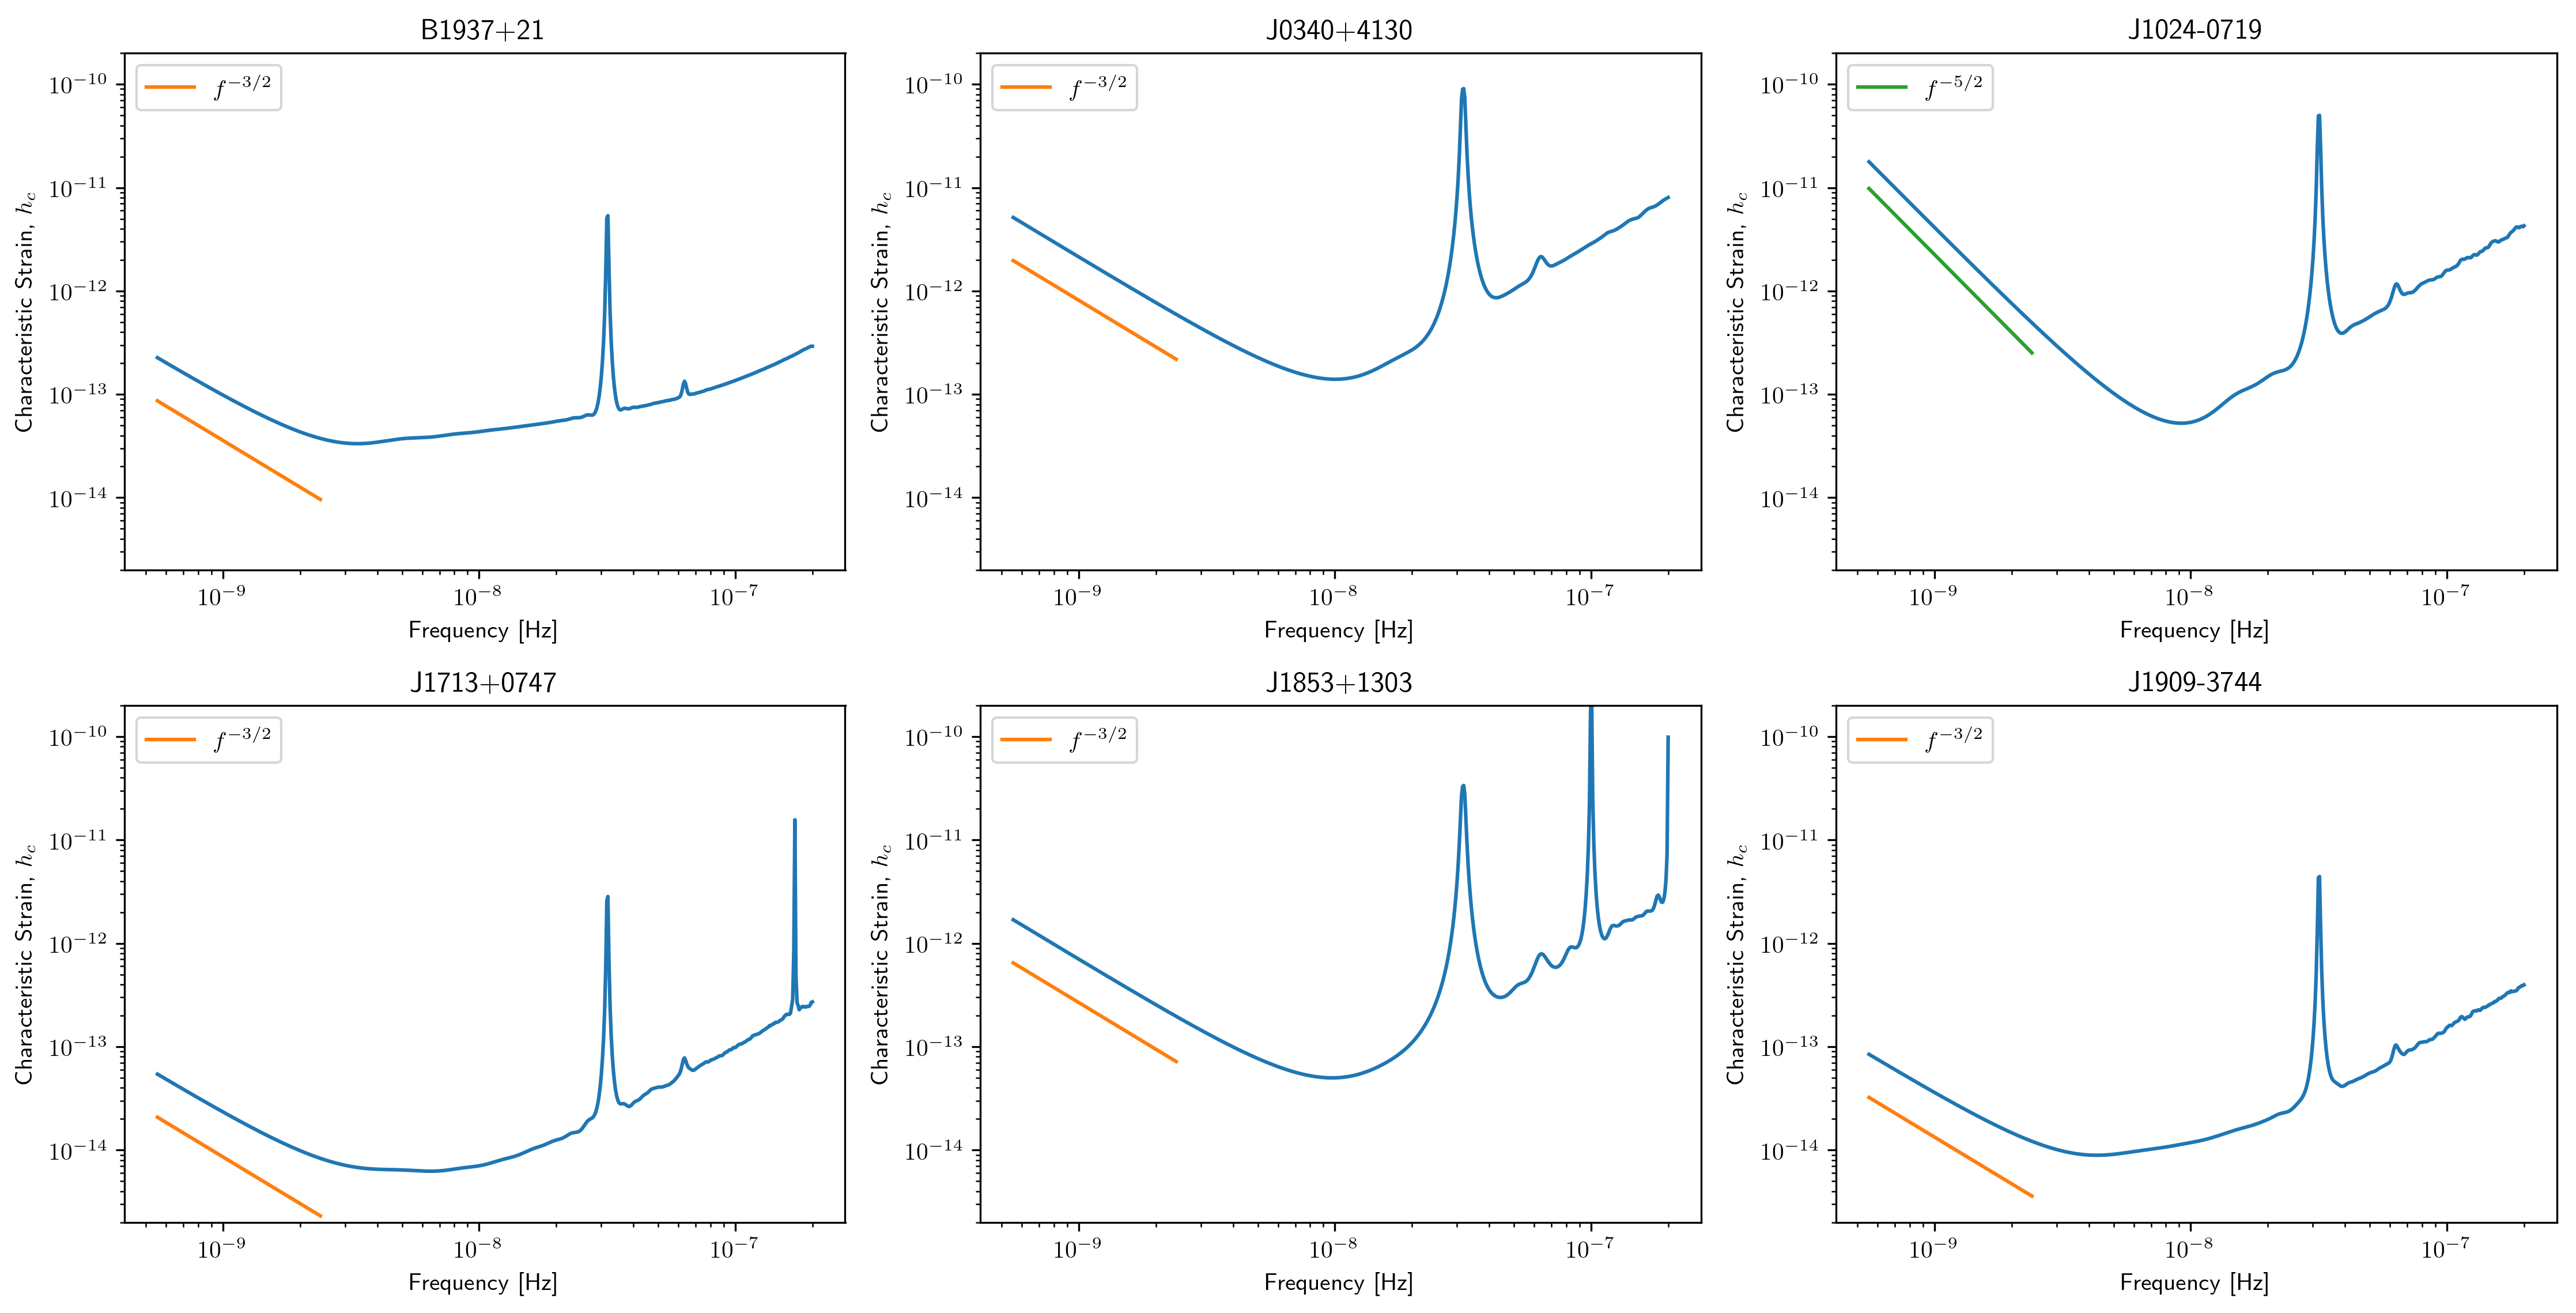

In [18]:
fig=plt.figure(figsize=[15,45])
j = 1
names = ['B1937+21','J0340+4130','J1024-0719',
         'J1713+0747','J1853+1303','J1909-3744',]
for sp,p in zip(specs,psrs):
    if p.name in names:
        fig.add_subplot(12,3,j)
        a = sp.h_c[0]/2*1e-14
        if p.name == 'J1024-0719':
            alp = -5/2
            a *= 8e-10
            plt.loglog(sp.freqs[:150],a*(sp.freqs[:150])**(alp),
                       color='C2',label=r'$f^{-5/2}$')
        else:
            alp = -3/2
            plt.loglog(sp.freqs[:150],a*(sp.freqs[:150])**(alp),
                       color='C1',label=r'$f^{-3/2}$')
        plt.ylim(2e-15,2e-10)
        plt.loglog(sp.freqs,sp.h_c, color='C0')
        plt.rc('text', usetex=True)
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Characteristic Strain, $h_c$')
        plt.legend(loc='upper left')
        plt.title(p.name)
        j+=1
fig.tight_layout()
plt.show()
plt.close()

Below sensitivity curves of the full PTA are plotted, with a few pulsars highlighted. 

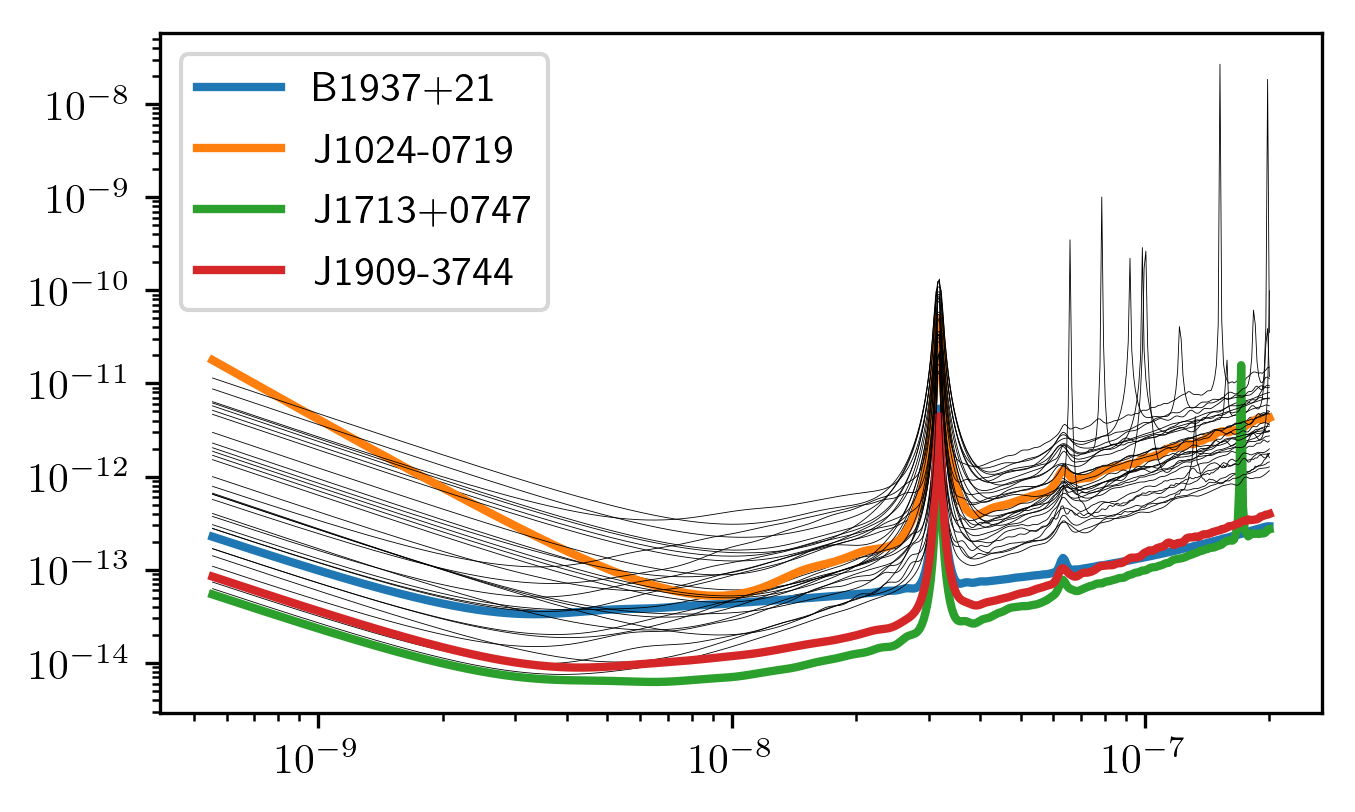

In [19]:
names = ['J1713+0747','B1937+21','J1909-3744','J1024-0719']
for sp,p in zip(specs,psrs):
    if p.name in names:
        plt.loglog(sp.freqs,sp.h_c,lw=2,label=p.name)
    else:
        plt.loglog(sp.freqs,sp.h_c, color='k',lw=0.2)

plt.legend()
plt.show()
plt.close()

## PTA Sensitivity Curves
Full PTA sensitivity curves are constructed by passing a list of `Spectrum` instances to either the `GWBSensitivity` class or `DeterSensitivity` class. See the Sensitivity Curve class for more details. 

In [20]:
ng11yr_sc = hsen.GWBSensitivityCurve(specs)

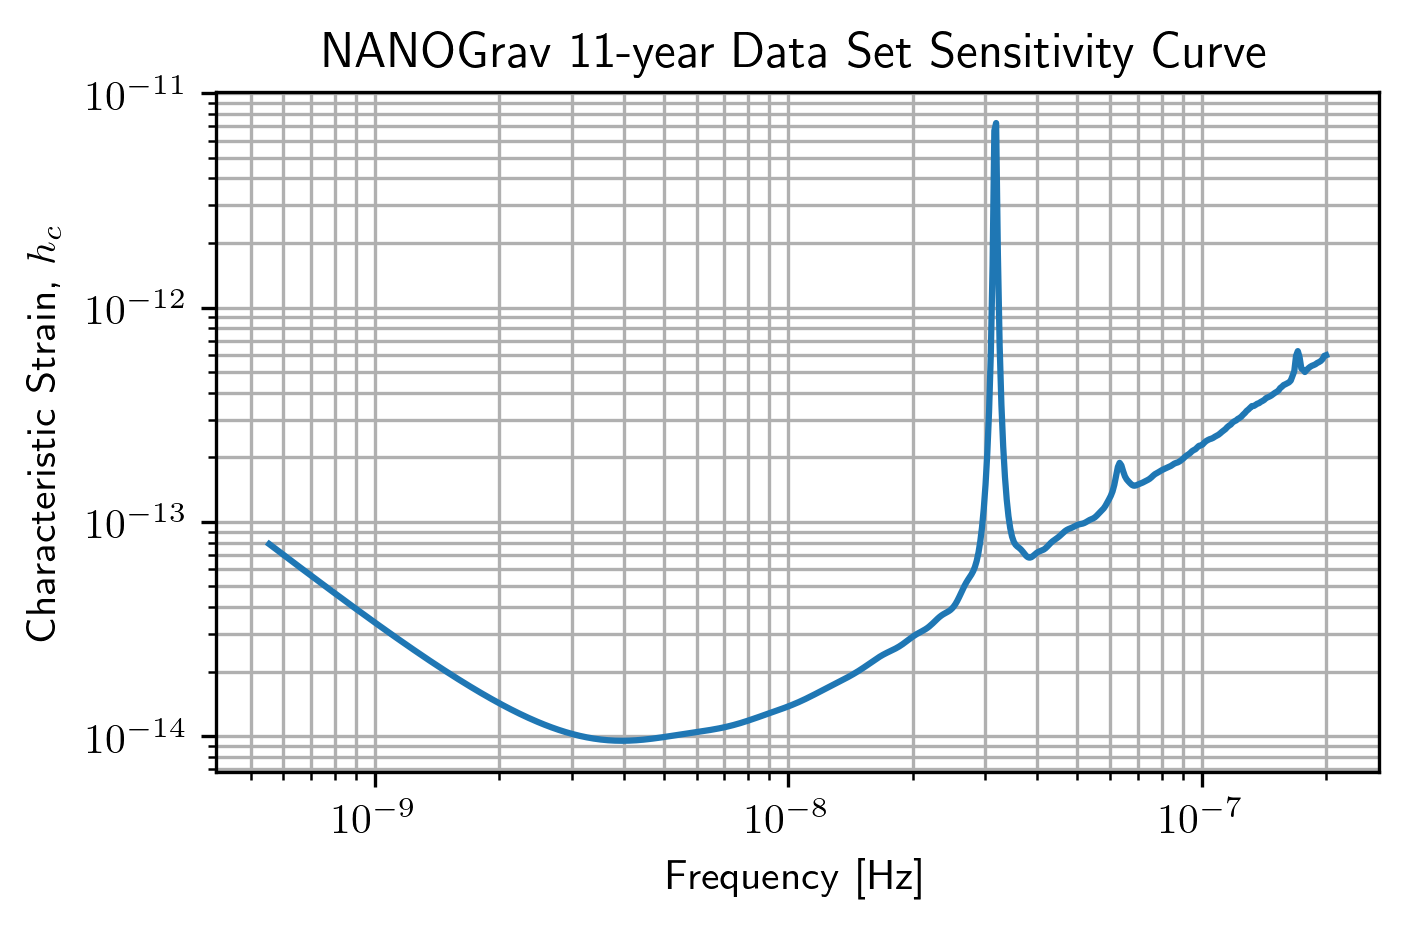

In [21]:
plt.loglog(ng11yr_sc.freqs,ng11yr_sc.h_c)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.title('NANOGrav 11-year Data Set Sensitivity Curve')
plt.grid(which='both')
# plt.ylim(1e-15,9e-12)
plt.show()

In [22]:
ng11yr_dsc = hsen.DeterSensitivityCurve(specs)

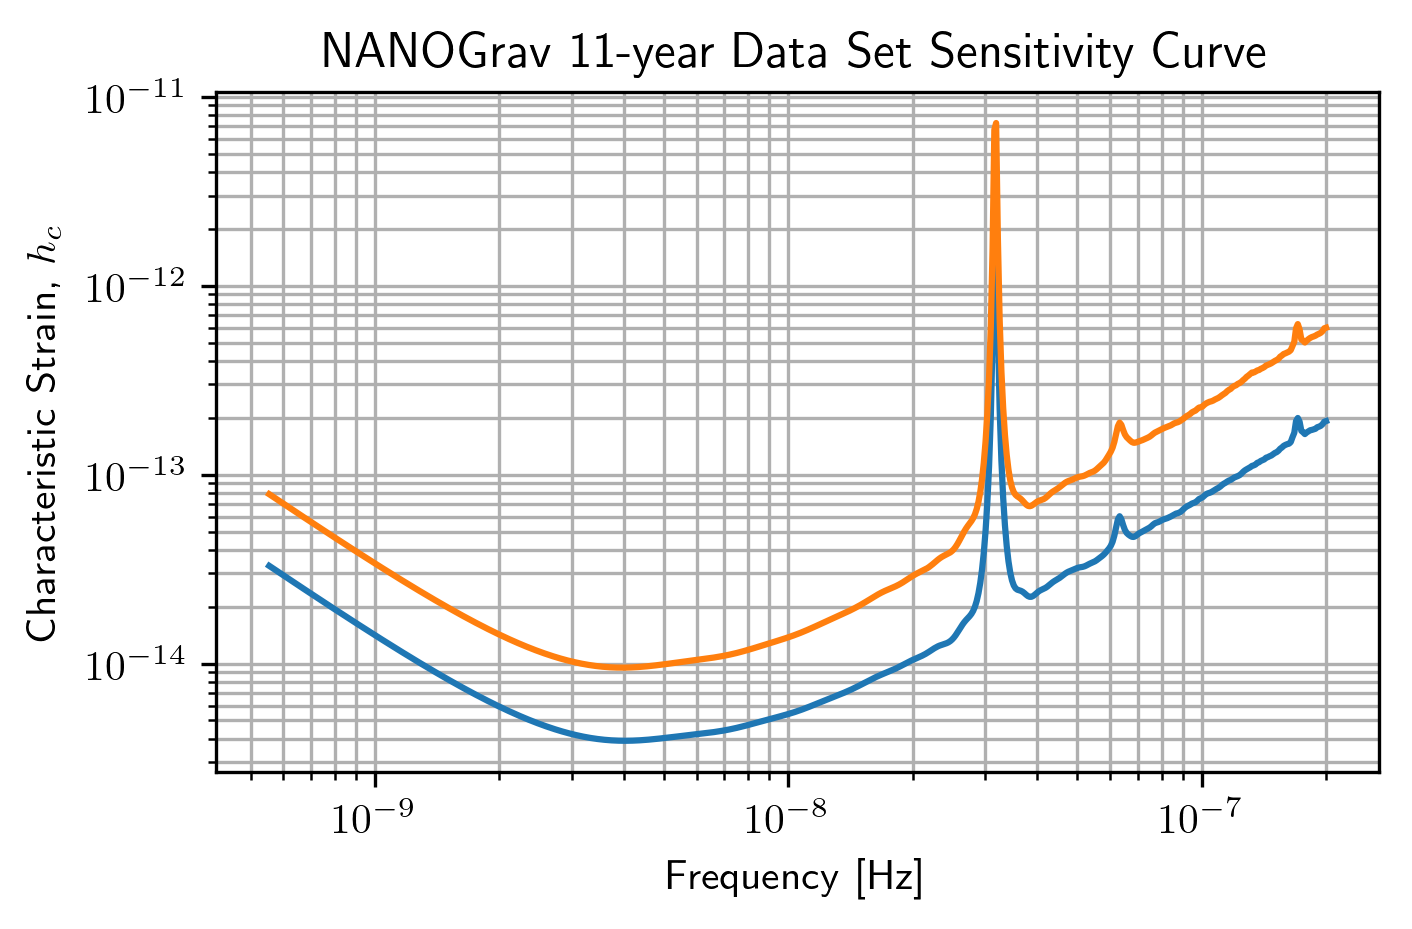

In [23]:
plt.loglog(ng11yr_dsc.freqs,ng11yr_dsc.h_c,label='Deterministic')
plt.loglog(ng11yr_sc.freqs,ng11yr_sc.h_c,label='Stochastic')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.title('NANOGrav 11-year Data Set Sensitivity Curve')
plt.grid(which='both')
# plt.ylim(1e-15,9e-12)
plt.show()

## Power-Law Integrated Sensitivity Curves
The `hasasia.sensitivity` module also contains functionality for calculating power-law integrated sensitivity curves. These can be used to calculate the sensitivity to a power-law GWB with a specific spectral or index, or an array of them.

In [24]:
#First for alpha=-2/3 (the default value).
SNR=1
hgw=hsen.Agwb_from_Seff_plaw(ng11yr_sc.freqs,
                             Tspan=Tspan,
                             SNR=SNR,
                             S_eff=ng11yr_sc.S_eff)
plaw_h = hgw*(ng11yr_sc.freqs/fyr)**(-2/3)

#And for an array of alpha values. 
alpha = np.linspace(-7/4,5/4,30)
h=hsen.Agwb_from_Seff_plaw(freqs=ng11yr_sc.freqs,Tspan=Tspan,SNR=SNR,
                           S_eff=ng11yr_sc.S_eff,alpha=alpha)

plaw = np.dot((ng11yr_sc.freqs[:,np.newaxis]/fyr)**alpha,
              h[:,np.newaxis]*np.eye(30))

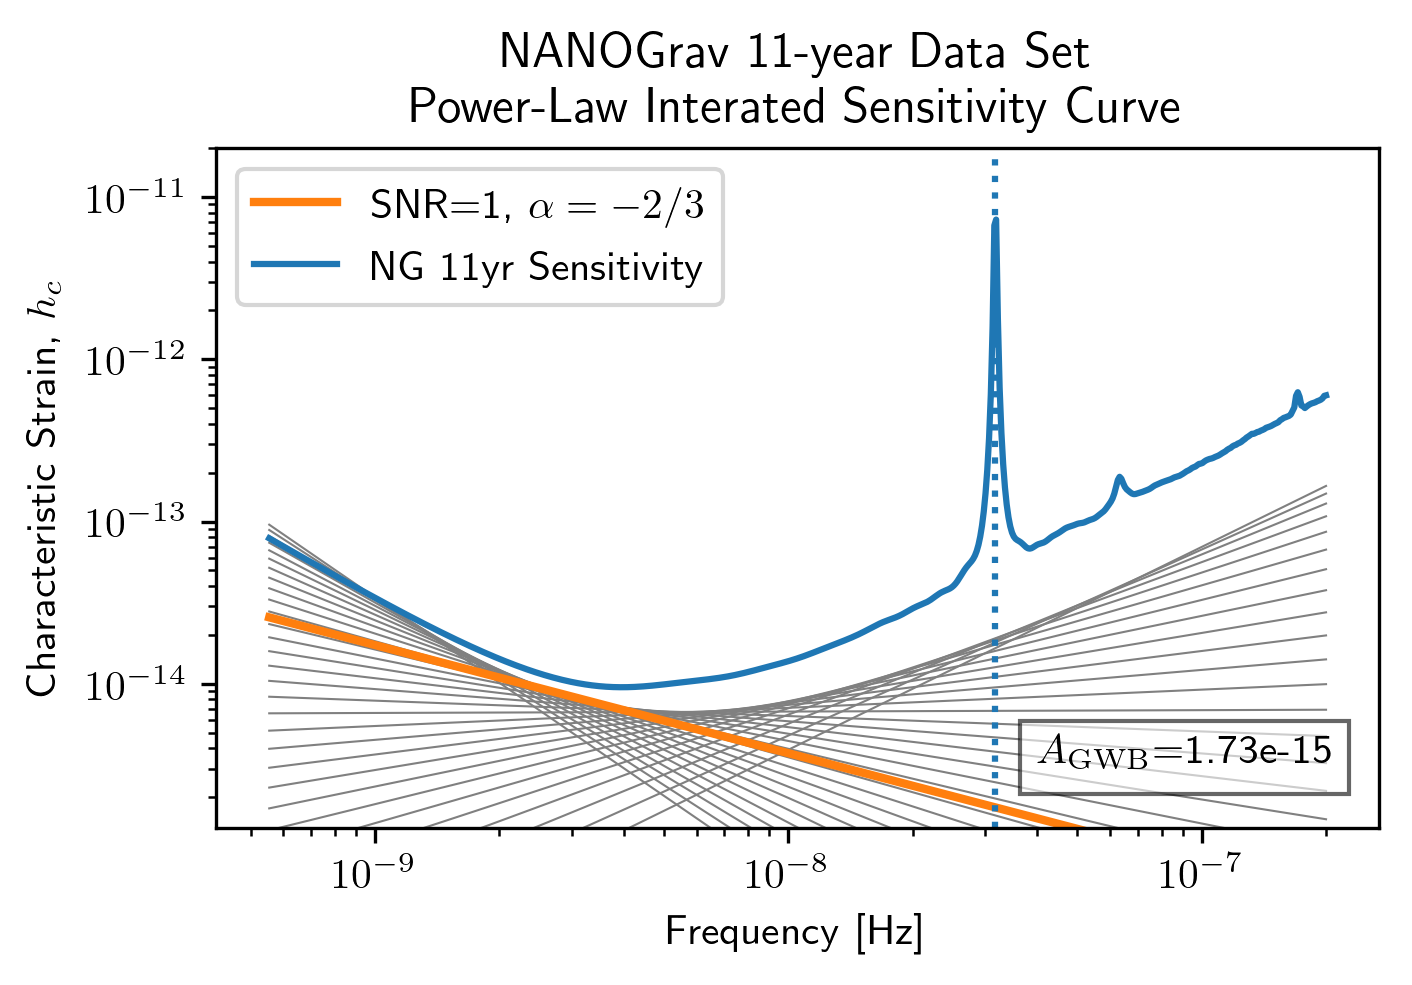

In [25]:
for ii in range(len(h)):
    plt.loglog(ng11yr_sc.freqs,plaw[:,ii],
               color='gray',lw=0.5)
plt.loglog(ng11yr_sc.freqs,plaw_h,color='C1',lw=2,
           label='SNR={0}, '.format(SNR)+r'$\alpha=-2/3$')  
plt.loglog(ng11yr_sc.freqs,ng11yr_sc.h_c, label='NG 11yr Sensitivity')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.axvline(fyr,linestyle=':')
plt.rc('text', usetex=True)
plt.title('NANOGrav 11-year Data Set\nPower-Law Interated Sensitivity Curve')
plt.ylim(hgw*0.75,2e-11)
plt.text(x=4e-8,y=3e-15,
         s=r'$A_{\rm GWB}$='+'{0:1.2e}'.format(hgw),
         bbox=dict(facecolor='white', alpha=0.6))
plt.legend(loc='upper left')
plt.show()

### Hellings-Downs Curve
The sensitivity curve classes have all of the information needed to make a Hellings-Downs curve for the pulsar pairs in the PTA.

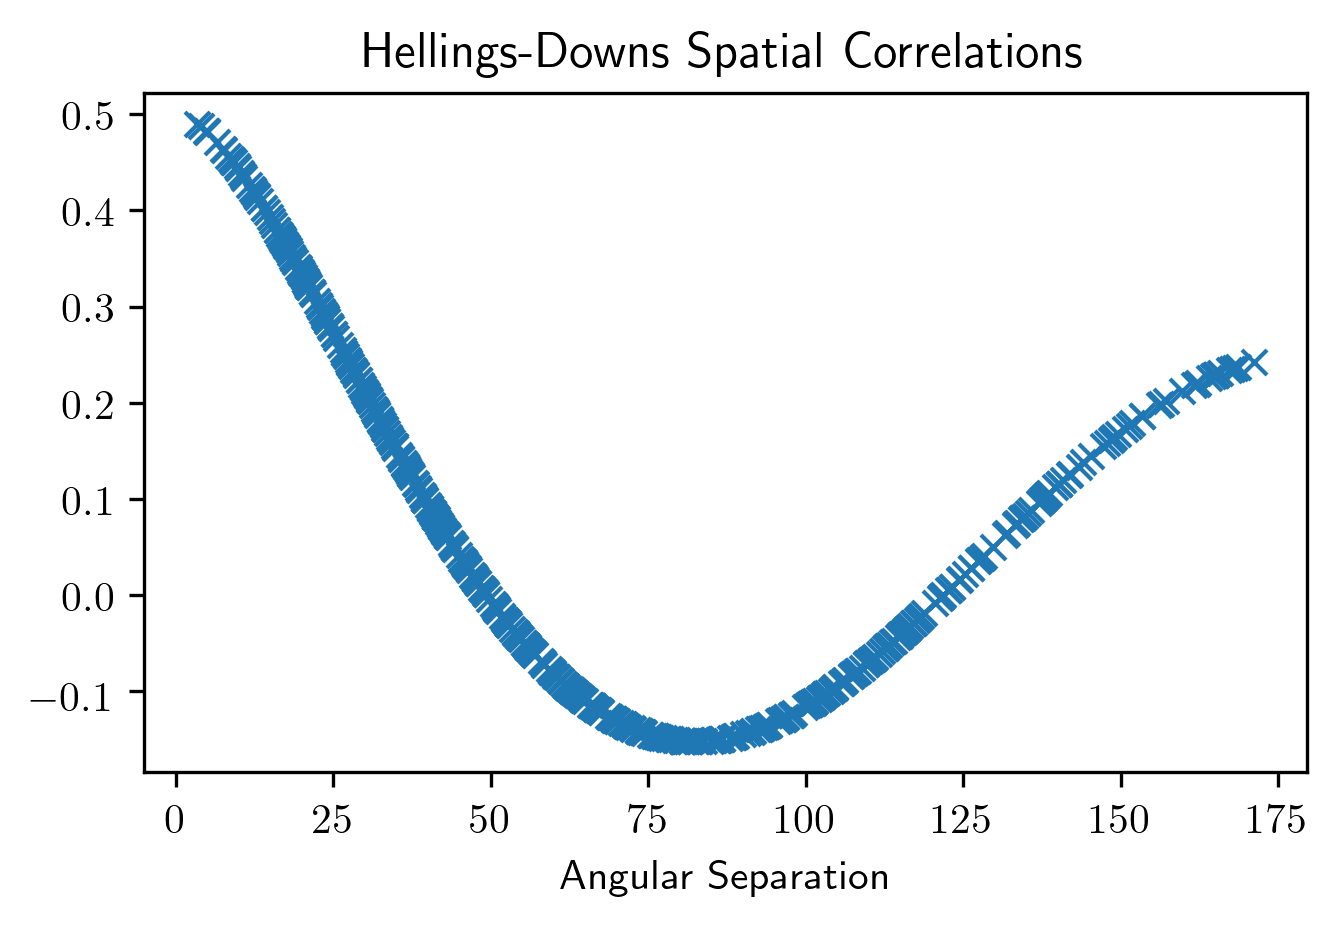

In [26]:
ThetaIJ,chiIJ,_,_=hsen.HellingsDownsCoeff(ng11yr_sc.phis,ng11yr_sc.thetas)
plt.plot(np.rad2deg(ThetaIJ),chiIJ,'x')
plt.title('Hellings-Downs Spatial Correlations')
plt.xlabel('Angular Separation')
plt.show()

### Pairwise Sensitivity Curves
The use can also access the pairwise sensitivity curves through the full PTA `GWBSensitivityCurve`. 

In [27]:
psr_names = [p.name for p in psrs]

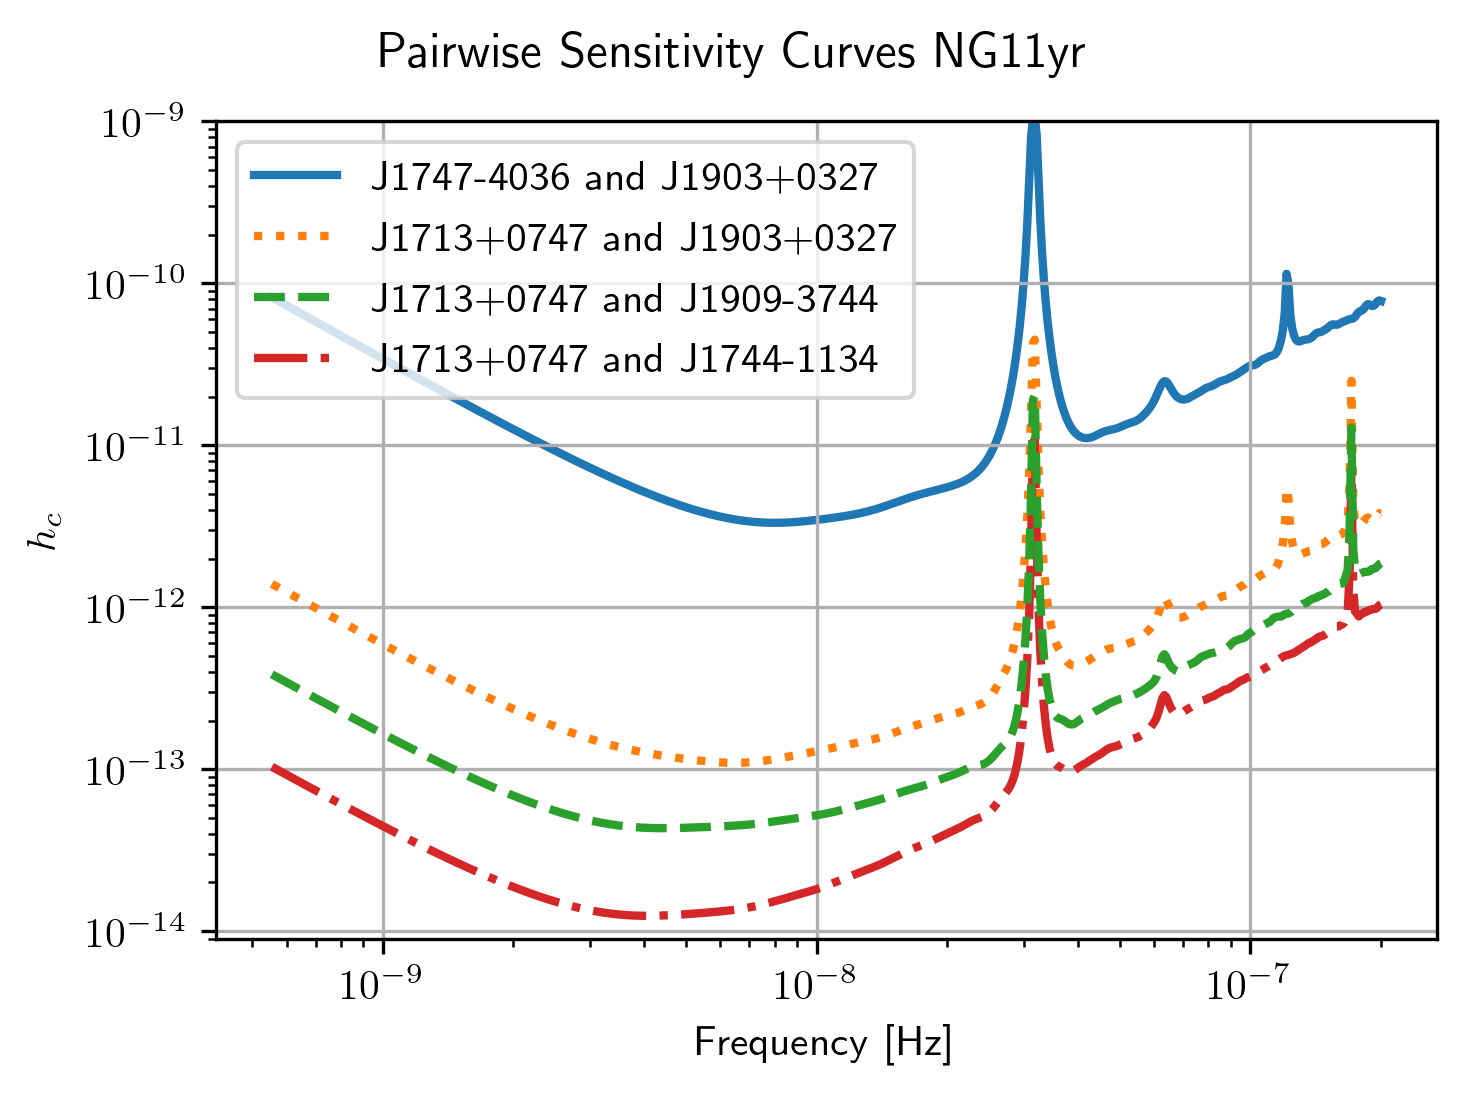

In [28]:
fig=plt.figure(figsize=[5,3.5])
j = 0
col = ['C0','C1','C2','C3']
linestyle = ['-',':','--','-.']
for nn,(ii,jj) in enumerate(zip(ng11yr_sc.pairs[0],ng11yr_sc.pairs[1])):
    pair = psr_names[ii], psr_names[jj]
    if ('J1747-4036' in pair and 'J1903+0327' in pair):
        lbl = '{0} and {1}'.format(psr_names[ii],psr_names[jj])
        plt.loglog(ng11yr_sc.freqs,
                   np.sqrt(ng11yr_sc.S_effIJ[nn]*ng11yr_sc.freqs),
                   label=lbl,lw=2, color=col[j],linestyle=linestyle[j],
                   zorder=1)
        j+=1
        
for nn,(ii,jj) in enumerate(zip(ng11yr_sc.pairs[0],ng11yr_sc.pairs[1])):
    pair = psr_names[ii], psr_names[jj]
    if ('J1713+0747' in pair and 'J1903+0327' in pair):
        lbl = '{0} and {1}'.format(psr_names[ii],psr_names[jj])
        plt.loglog(ng11yr_sc.freqs,
                   np.sqrt(ng11yr_sc.S_effIJ[nn]*ng11yr_sc.freqs),
                   label=lbl,lw=2, color=col[j],linestyle=linestyle[j],
                   zorder=2)
        j+=1
        
for nn,(ii,jj) in enumerate(zip(ng11yr_sc.pairs[0],ng11yr_sc.pairs[1])):
    pair = psr_names[ii], psr_names[jj]
    if ('J1713+0747' in pair and 'J1909-3744' in pair):
        lbl = '{0} and {1}'.format(psr_names[ii],psr_names[jj])
        plt.loglog(ng11yr_sc.freqs,
                   np.sqrt(ng11yr_sc.S_effIJ[nn]*ng11yr_sc.freqs),
                   label=lbl,lw=2, color=col[j],linestyle=linestyle[j],
                   zorder=4)
        j+=1   
        
for nn,(ii,jj) in enumerate(zip(ng11yr_sc.pairs[0],ng11yr_sc.pairs[1])):
    pair = psr_names[ii], psr_names[jj]
    if ('J1713+0747' in pair and 'J1744-1134' in pair):
        lbl = '{0} and {1}'.format(psr_names[ii],psr_names[jj])
        plt.loglog(ng11yr_sc.freqs,
                   np.sqrt(ng11yr_sc.S_effIJ[nn]*ng11yr_sc.freqs),
                   label=lbl,lw=2, color=col[j],linestyle=linestyle[j],
                   zorder=3)
        j+=1        

plt.rc('text', usetex=True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('$h_c$')
plt.ylim(9e-15,1e-9)
plt.legend(loc='upper left')
plt.grid()
# plt.rcParams.update({'font.size':11})
fig.suptitle('Pairwise Sensitivity Curves NG11yr',y=1.03)
fig.tight_layout()
plt.show()
plt.close()

## SkySensitivity with Real Data
Here we recap the SkySensitivity tutorial using the real NANOGrav data. See the `SkySenstivity` tutorial for more details. 

In [29]:
#healpy imports
import healpy as hp
import astropy.units as u
import astropy.constants as c

In [30]:
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [31]:
SM = hsky.SkySensitivity(specs,theta_gw, phi_gw)

In [32]:
min_idx = np.argmin(ng11yr_sc.S_eff)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


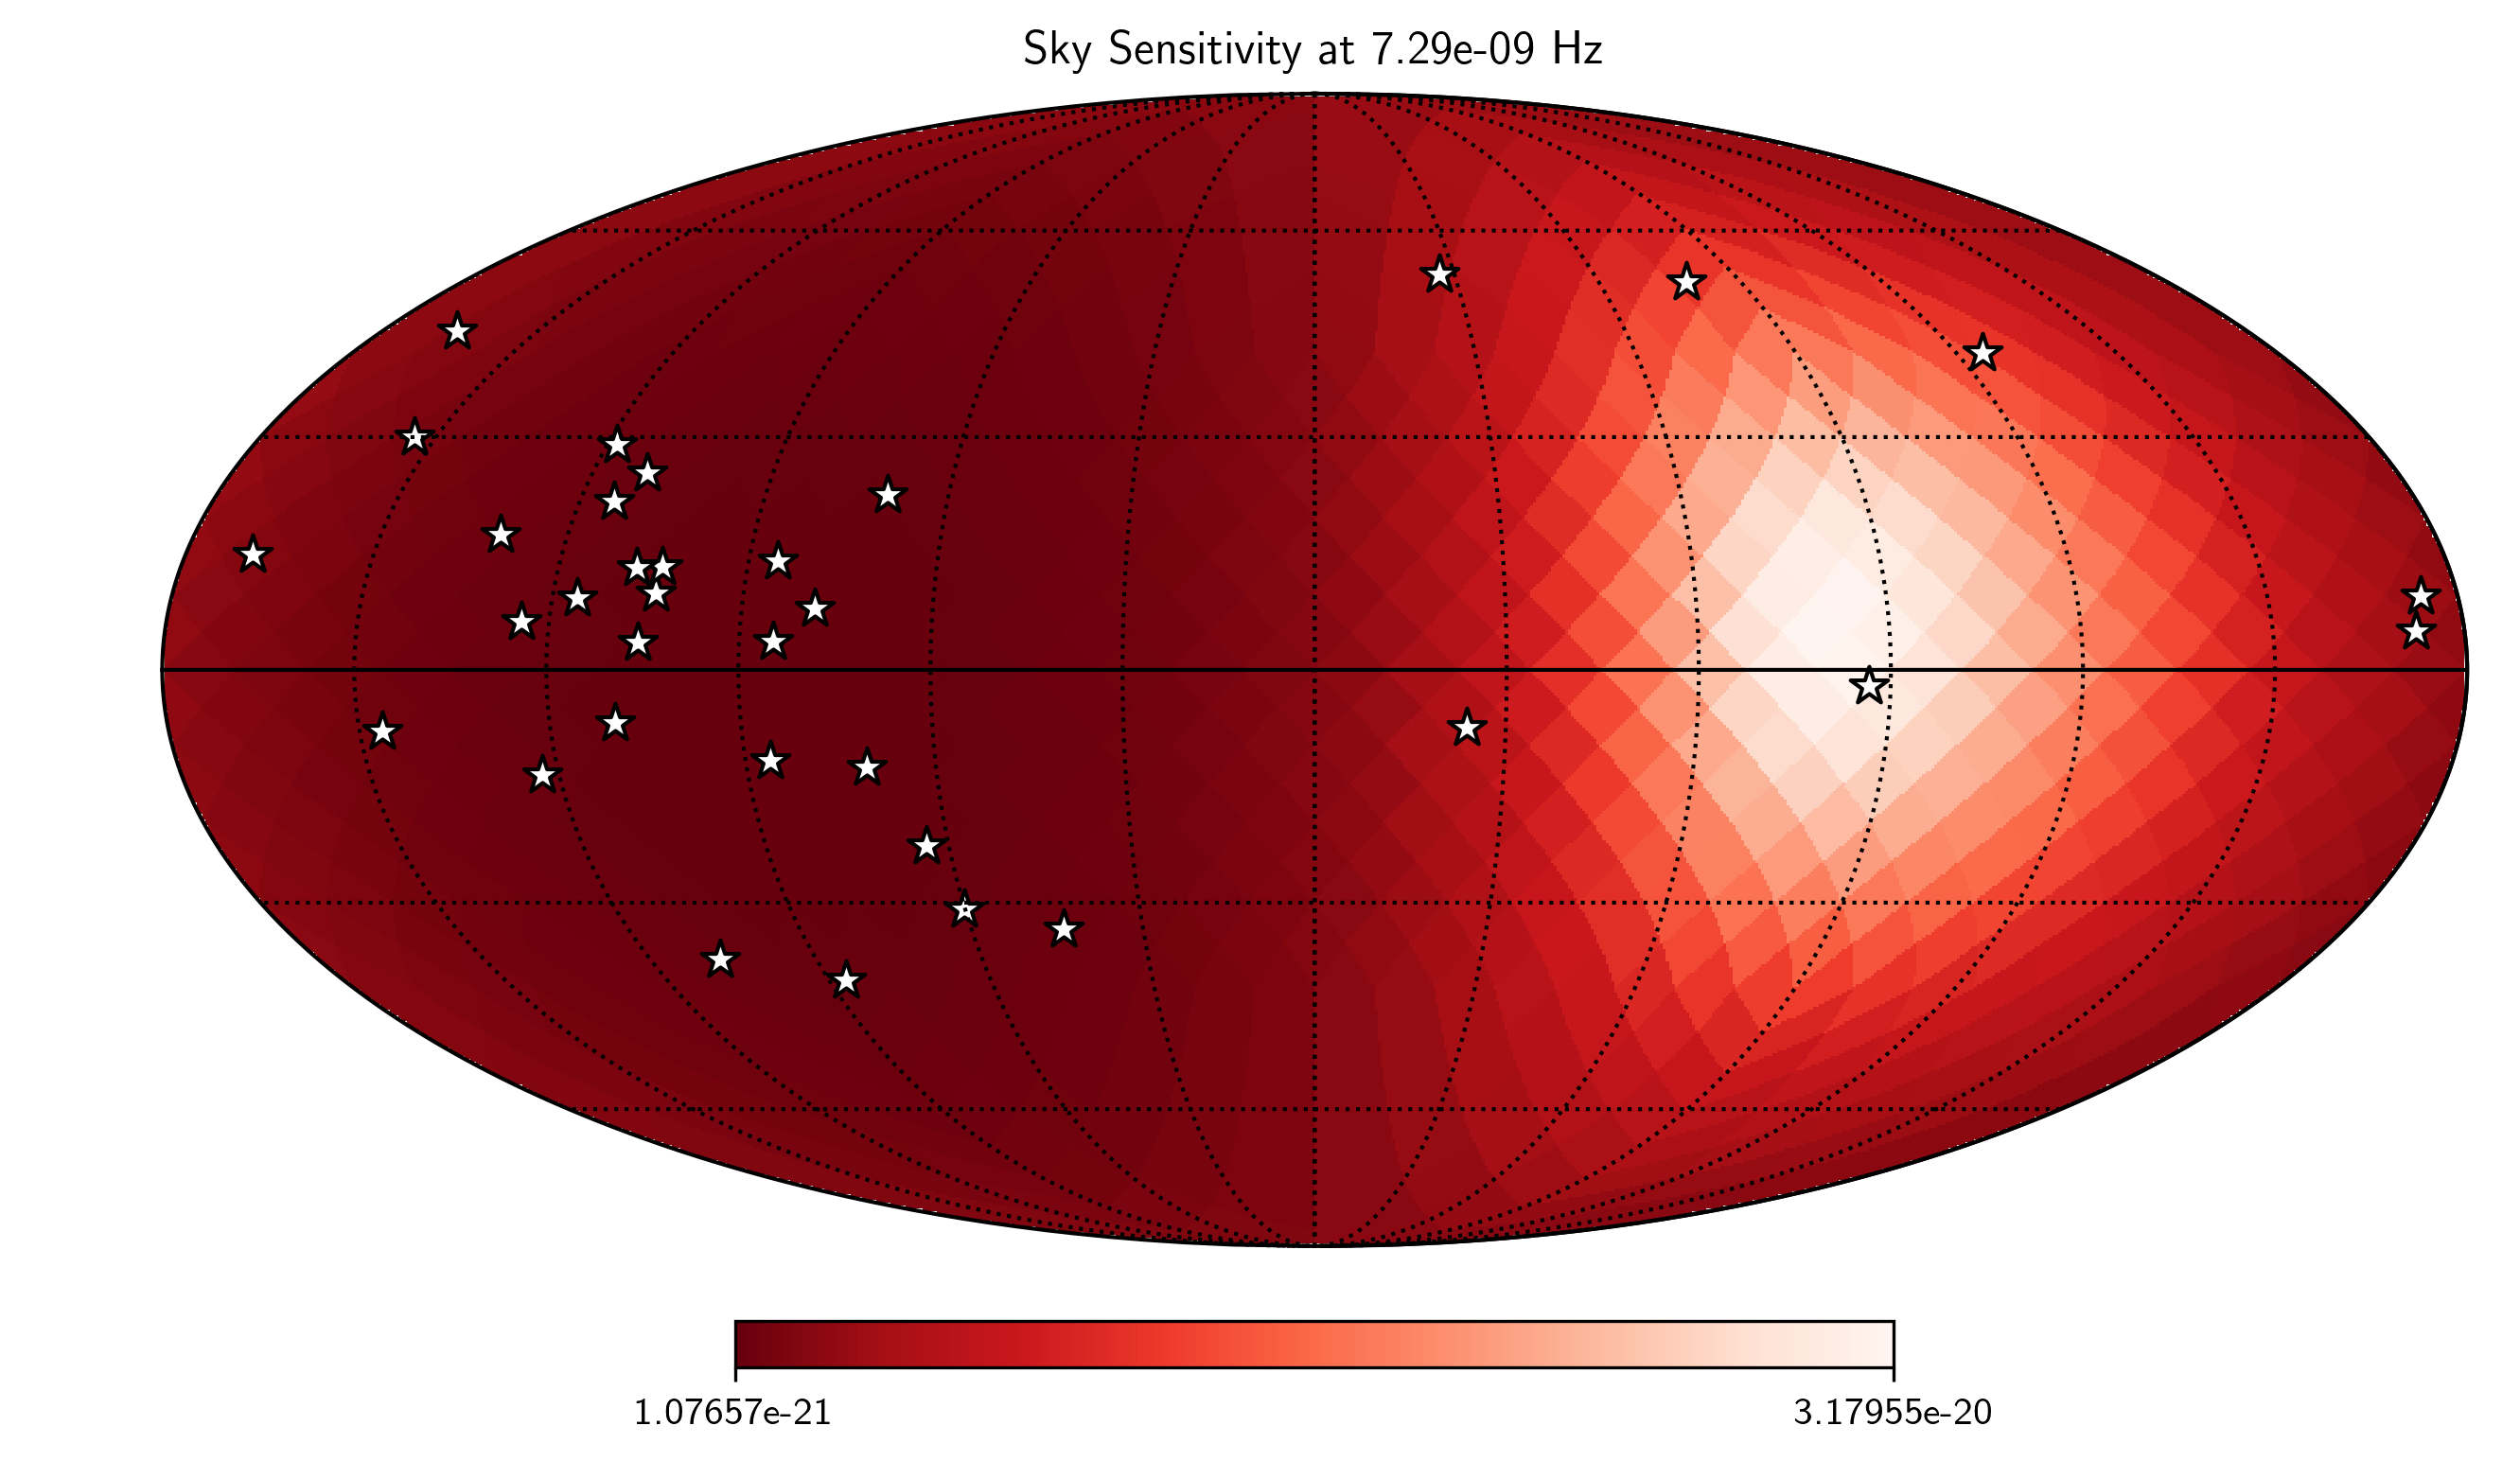

In [33]:
idx = min_idx
hp.mollview(SM.S_effSky[idx],
            title="Sky Sensitivity at {0:2.2e} Hz".format(SM.freqs[idx]),
            cmap='Reds_r',rot=(180,0,0))
hp.visufunc.projscatter(SM.thetas,SM.phis,marker='*',
                        color='white',edgecolors='k',s=100)
hp.graticule()
plt.show()

In [34]:
f0=8e-9
hcw = hsky.h_circ(1e9,120,f0,Tspan,SM.freqs).to('').value
SkySNR = SM.SNR(hcw)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


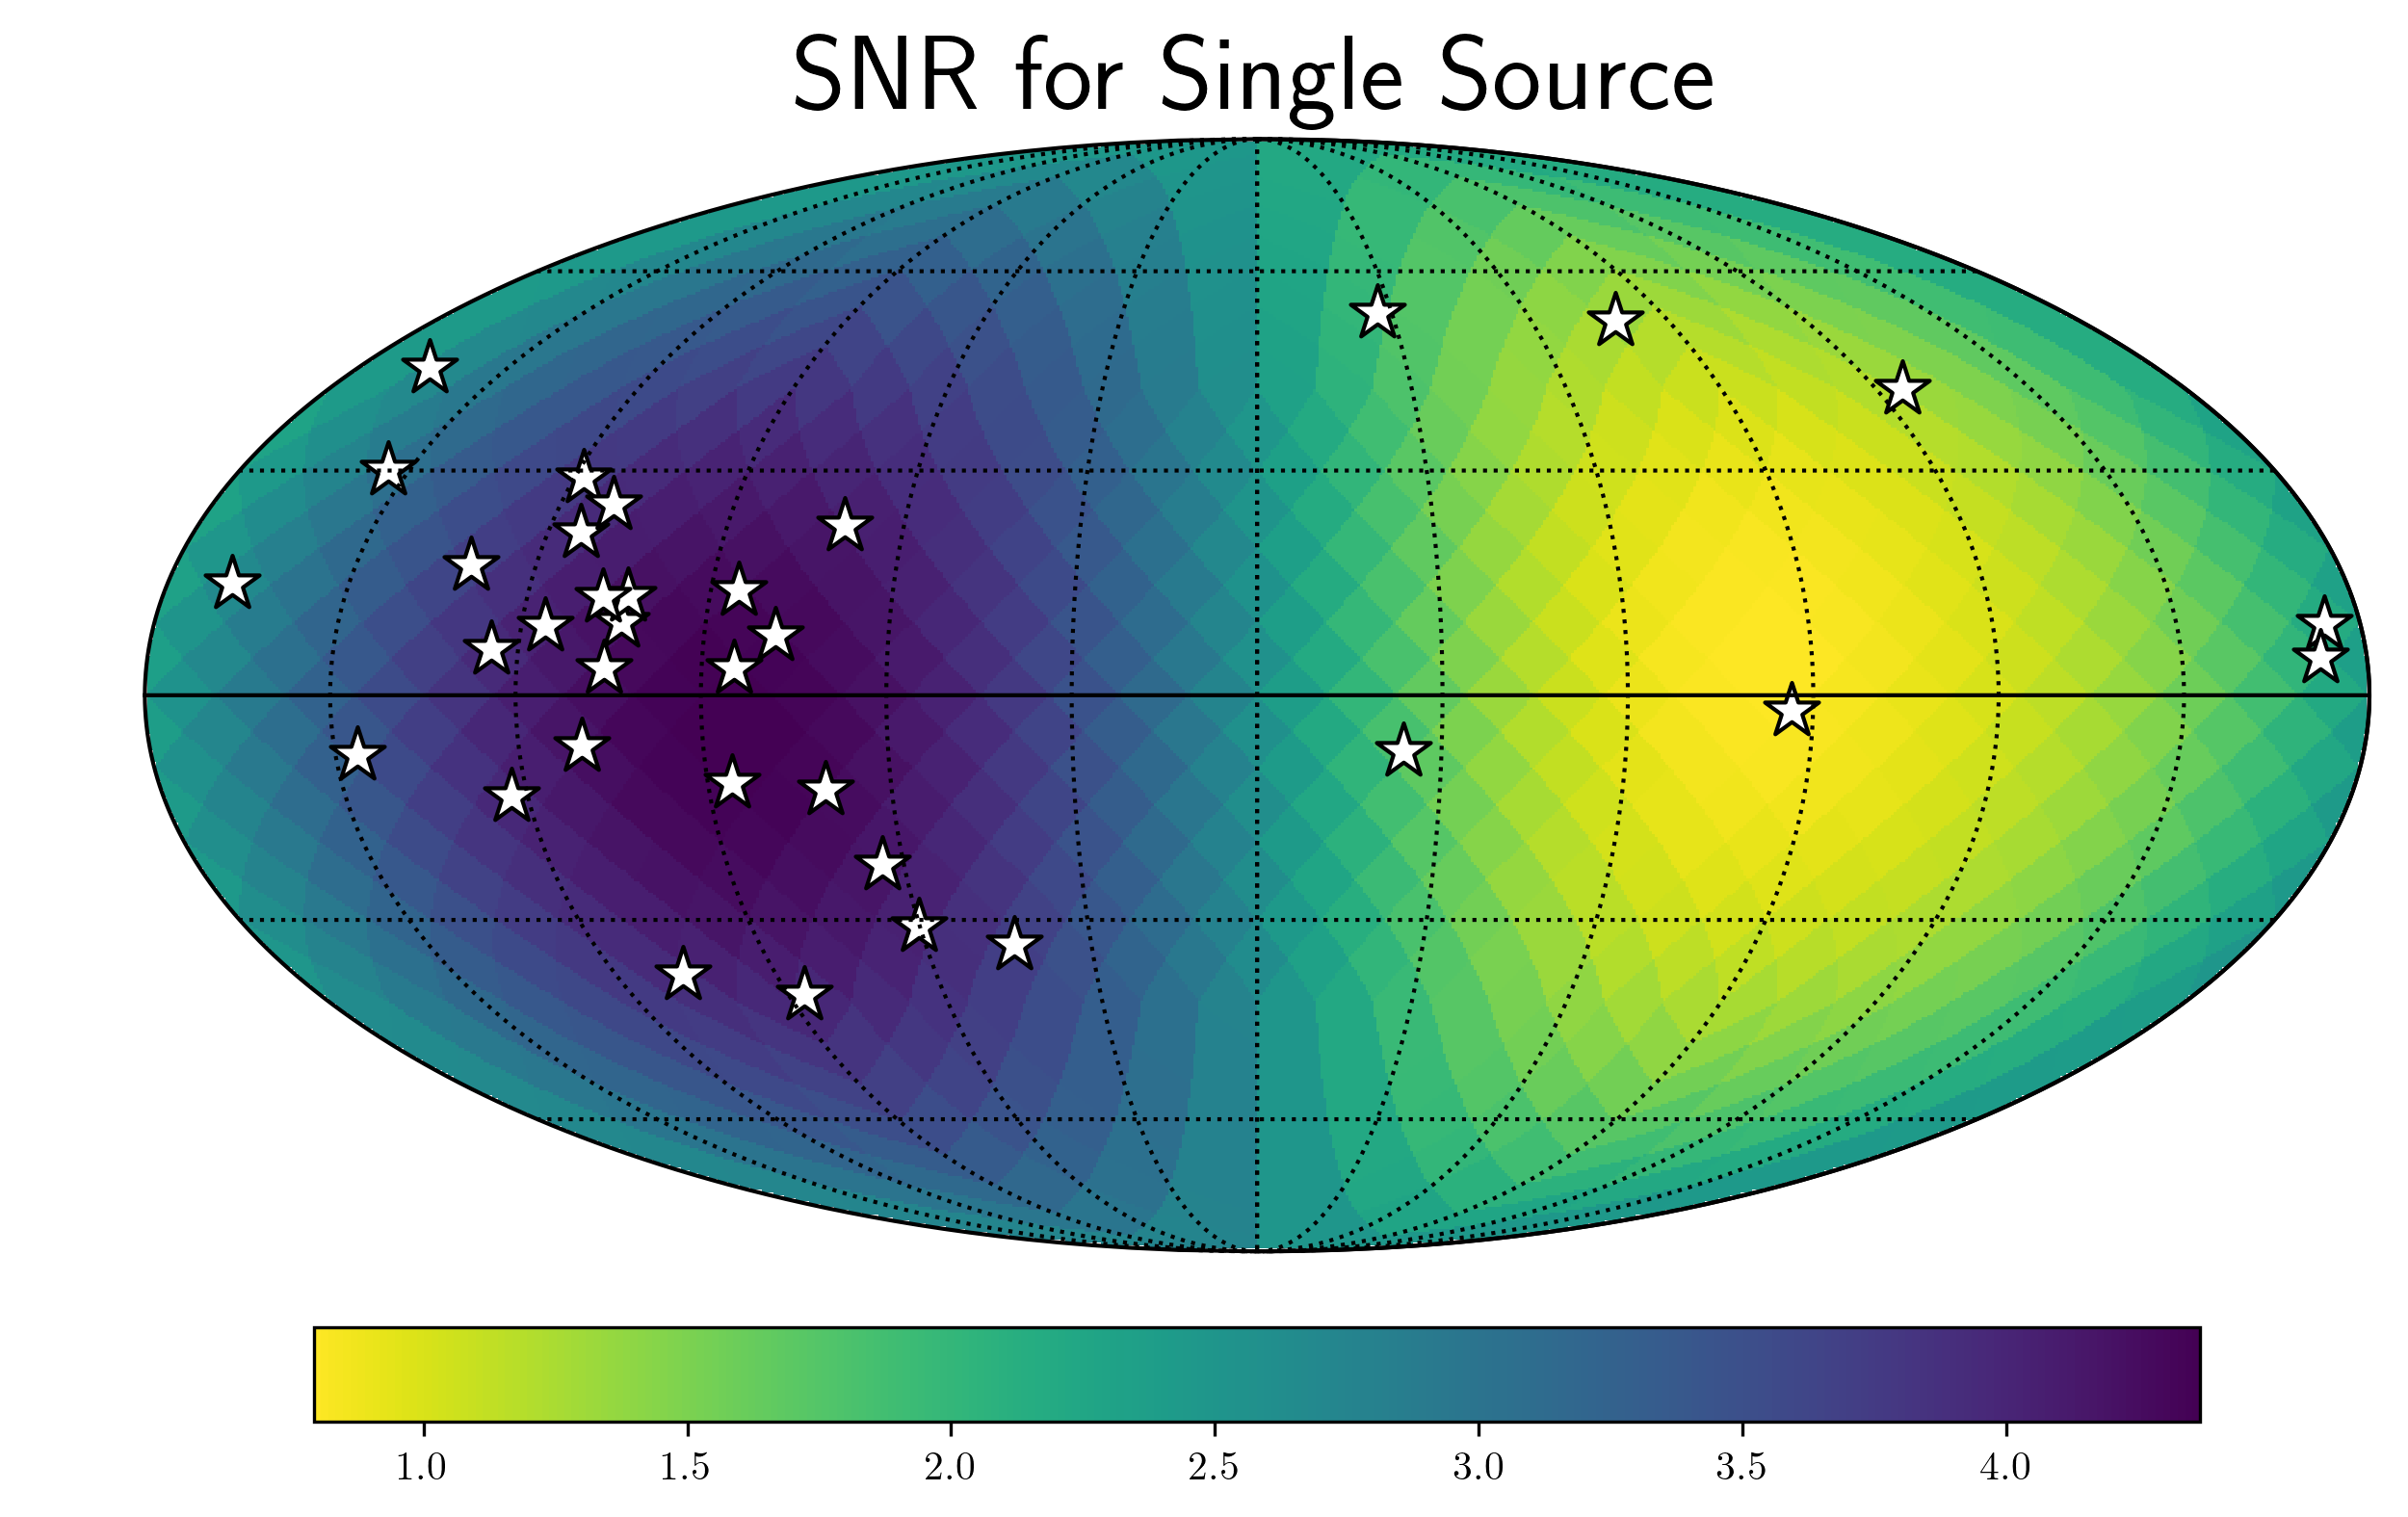

In [35]:
plt.rc('text', usetex=True)
hp.mollview(SkySNR,rot=(180,0,0),#np.log10(1/SM.Sn[idx]),"SNR with Single Source"
            cmap='viridis_r',cbar=None,title='')
hp.visufunc.projscatter(SM.thetas,SM.phis,marker='*',
                        color='white',edgecolors='k',s=200)
hp.graticule()
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax,orientation='horizontal',shrink=0.8,pad=0.05)

plt.rcParams.update({'font.size':22,'text.usetex':True})
ax.set_title("SNR for Single Source")
plt.show()

In [36]:
import matplotlib.ticker as ticker

In [37]:
hdivA= hcw / hsky.h0_circ(1e9,120,f0)
Agw = SM.A_gwb(hdivA).to('').value

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


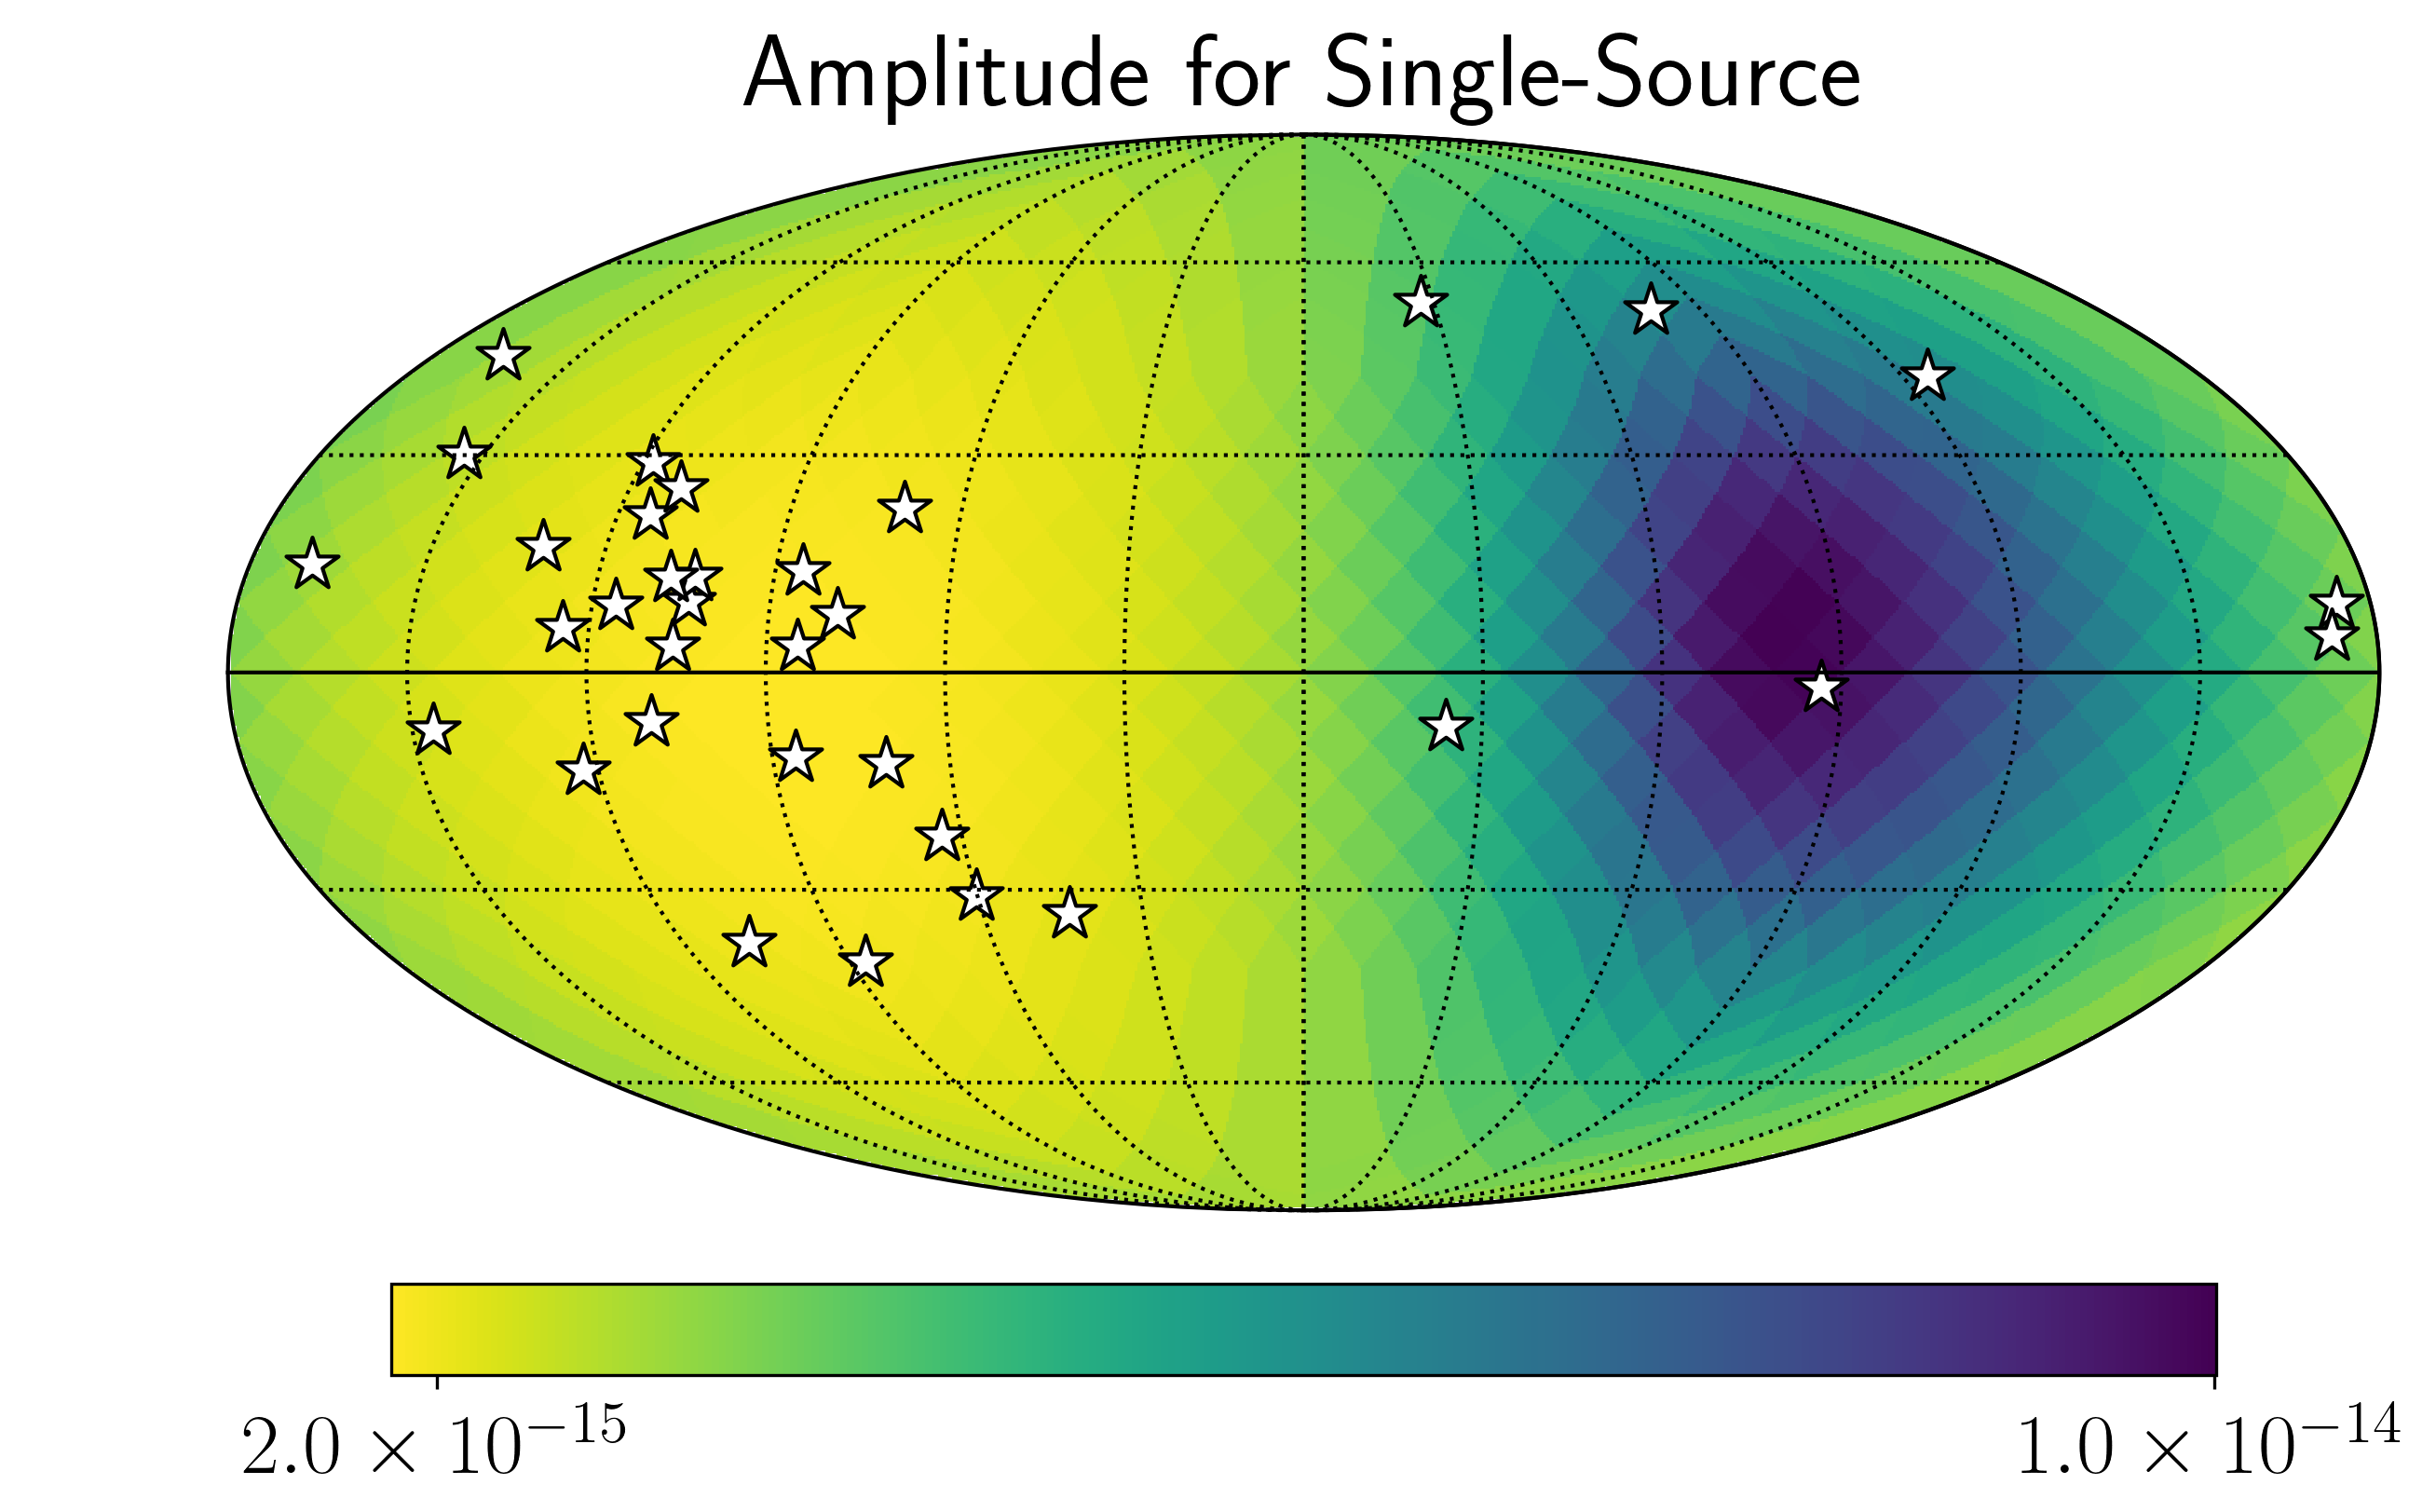

In [38]:
idx = min_idx
hp.mollview(Agw,rot=(180,0,0),
            title="",cbar=None,
            cmap='viridis_r')
hp.visufunc.projscatter(SM.thetas,SM.phis,marker='*',
                        color='white',edgecolors='k',s=200)
hp.graticule()
# 
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar_ticks = [2.02e-15,1e-14]

plt.rcParams.update({'font.size':22,'text.usetex':True})
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)
ax.set_title("Amplitude for Single-Source")
cmap = fig.colorbar(image, ax=ax,orientation='horizontal',
                    ticks=cbar_ticks,shrink=0.8,
                    format=ticker.FuncFormatter(fmt),pad=0.05)
plt.show()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


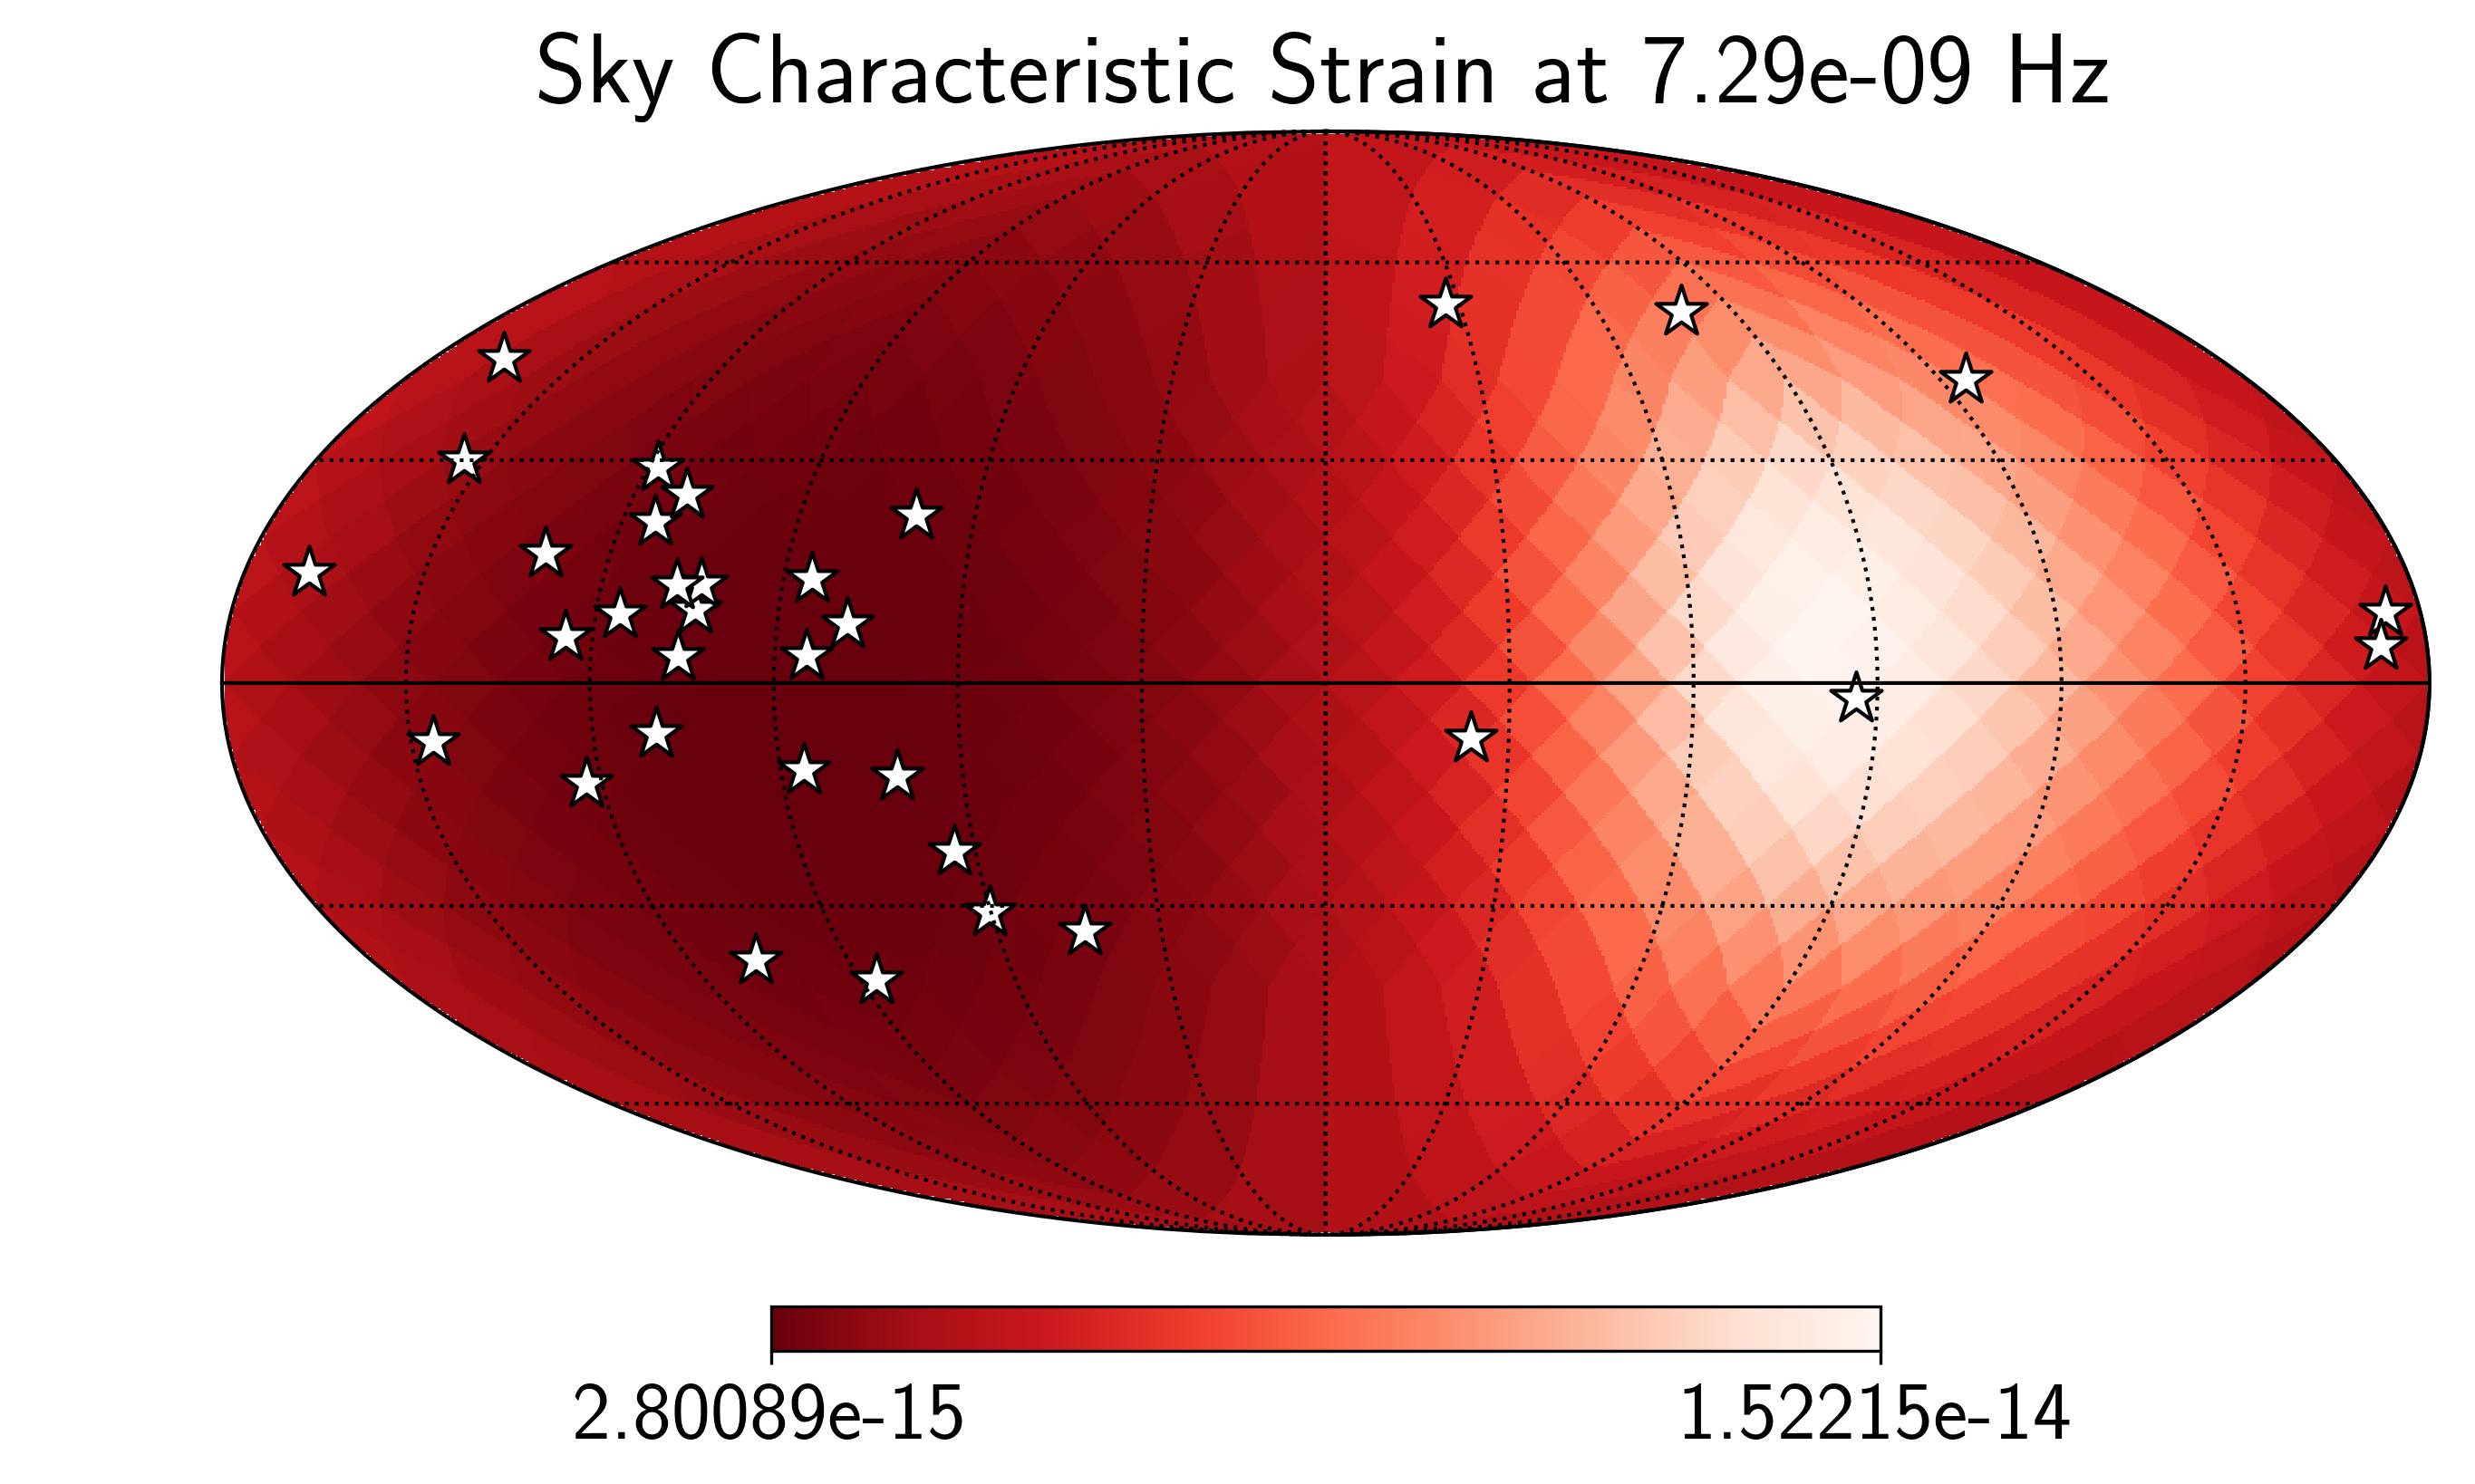

In [39]:
idx = min_idx
hp.mollview(SM.h_c[idx],
            title="Sky Characteristic Strain at {0:2.2e} Hz".format(SM.freqs[idx]),
            cmap='Reds_r',rot=(180,0,0))
hp.visufunc.projscatter(SM.thetas,SM.phis,marker='*',
                        color='white',edgecolors='k',s=200)
hp.graticule()
plt.show()